### Decision Tree Regression

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
import pandas as pd
df=pd.read_csv("PowerPlant.csv")

### Data Quality Check

In [3]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [4]:
df.shape

(9568, 5)




Atmospherer temperature
vaccum pressure in boiler
atmospheric pressure
relative humidity
power output in meggawatts

In [5]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(41)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [10]:
df=df.drop_duplicates(keep="first").reset_index(drop=True)

In [11]:
df.duplicated().sum()

np.int64(0)

In [13]:
X=df.drop(columns="PE")

In [15]:
Y=df["PE"]

In [16]:
Y.head()

0    480.48
1    445.75
2    438.76
3    453.09
4    464.43
Name: PE, dtype: float64

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


numpipe=make_pipeline(SimpleImputer(strategy="mean"),StandardScaler()).set_output(transform="pandas")

<Axes: xlabel='PE', ylabel='Count'>

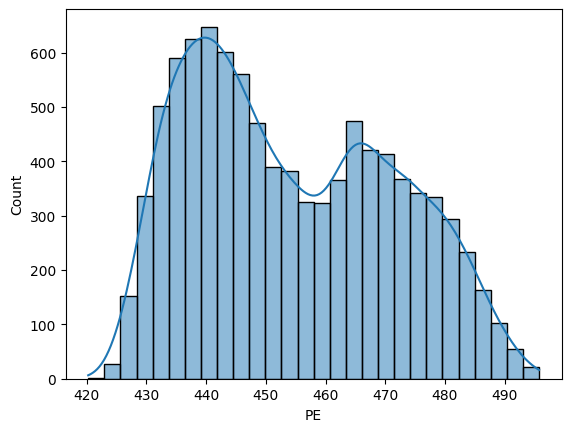

In [21]:
import seaborn as sns
sns.histplot(df,x="PE",kde=True)

In [22]:
X_pre=numpipe.fit_transform(X)

In [23]:
X_pre

,AT,V,AP,RH
0,-1.520448,-1.066041,-0.403535,1.141599
1,0.534897,0.330813,-0.309262,0.059223
2,1.354348,0.205475,-1.024725,-2.151400
3,-0.079020,-0.362884,-1.012941,0.236538
4,-1.055645,-1.074713,0.655349,1.633837
...,...,...,...,...
9522,-0.609648,-0.423583,-0.241925,-0.027724
9523,1.847362,1.864831,-0.494441,-0.932100
9524,-0.492776,-0.863450,0.162101,0.364561
9525,-0.269777,0.439598,0.899448,1.459261


In [24]:
from sklearn.model_selection import train_test_split


xtrain,xtest,ytrain,ytest=train_test_split(X_pre,Y,test_size=0.2,random_state=21)

In [29]:
xtest.shape

(1906, 4)

In [31]:
from sklearn.tree import DecisionTreeRegressor
model1=DecisionTreeRegressor(
    max_depth=1
    ,min_samples_leaf=5,
    min_samples_split=5,
    criterion="absolute_error"
)
model1.fit(xtrain,ytrain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=1,
                      min_samples_leaf=5, min_samples_split=5)

In [32]:
model1.score(xtrain,ytrain)

0.7177923616571229

In [33]:
model1.score(xtest,ytest)

0.7199818259925854

### Hpyer Parameter Tuning

In [34]:
params={
    "max_depth":[2,3,4,5,6,7,8,9,10],
    "min_samples_split":[5,6,7,8,9,10],
    "min_samples_leaf":[5,6,7,8,9,10],
    "criterion":["squared_error","absolute_error"]
}

In [35]:
from sklearn.model_selection import RandomizedSearchCV
dtr=DecisionTreeRegressor()
rscv=RandomizedSearchCV(dtr,param_distributions=params,cv=5,scoring="r2",n_jobs=-1)
rscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [5, 6, 7, 8, 9, 10],
                                        'min_samples_split': [5, 6, 7, 8, 9,
                                                              10]},
                   scoring='r2')

In [36]:
rscv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 9,
 'max_depth': 9,
 'criterion': 'squared_error'}

In [37]:
rscv.best_score_

np.float64(0.9399298875425416)

In [38]:
best_dtr=rscv.best_estimator_
best_dtr

DecisionTreeRegressor(max_depth=9, min_samples_leaf=9, min_samples_split=5)

### Evaluate

In [39]:
best_dtr.score(xtrain,ytrain)

0.9591011430168913

In [40]:
best_dtr.score(xtest,ytest)

0.9432125358211183

In [43]:

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error,r2_score


def evaluate(model,x,y):
    ypred=model.predict(x)
    rmse=root_mean_squared_error(y,ypred)
    mae=mean_absolute_error(y,ypred)
    mape=mean_absolute_percentage_error(y,ypred)
    r2=r2_score(y,ypred)
    print(f"RMSE :{rmse:.2f}")
    print(f"MAE:{mae:.2f}")
    print(f"MAPE:{mape:.2%}")
    print(f"R2:{r2:.2f}")

In [45]:
evaluate(best_dtr,xtrain,ytrain)

RMSE :3.44
MAE:2.54
MAPE:0.56%
R2:0.96


In [47]:
evaluate(best_dtr,xtest,ytest)

RMSE :4.07
MAE:2.99
MAPE:0.66%
R2:0.94


In [48]:
y_pred_test=best_dtr.predict(xtest)
y_pred_test[0:5]

array([447.65225806, 447.625     , 462.90147287, 466.84029412,
       462.90147287])

In [49]:
ytest.head()

4899    453.03
2941    446.15
1770    459.98
1450    466.27
5393    459.83
Name: PE, dtype: float64

### Plotting Decison Tree`m`

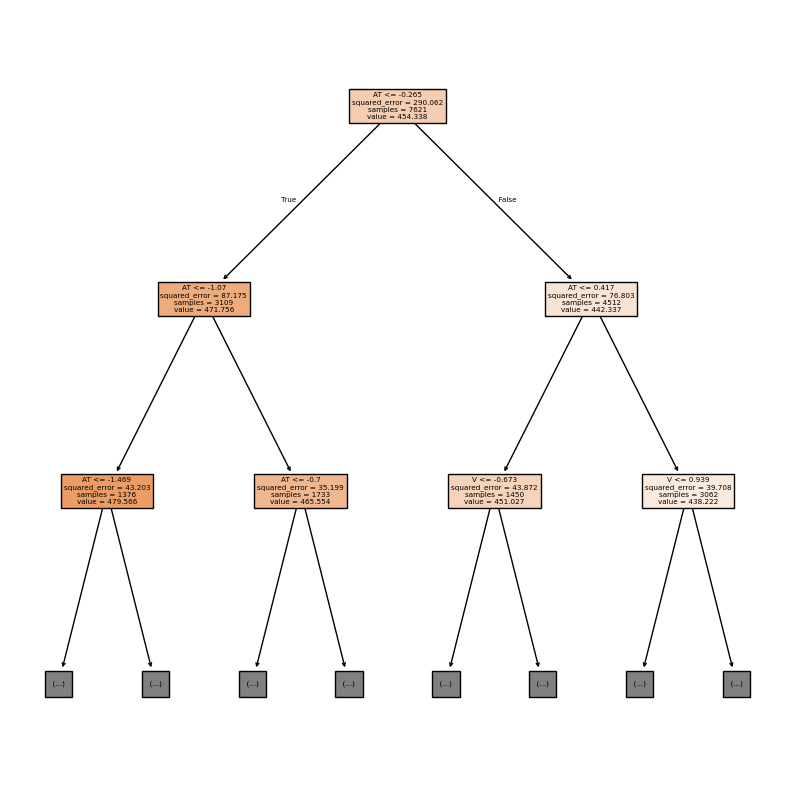

In [53]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(best_dtr,feature_names=xtrain.columns,filled=True,max_depth=2)
plt.show()

### Feature Importance

In [54]:
best_dtr.feature_importances_

array([0.93513227, 0.04678163, 0.00984013, 0.00824596])

In [55]:
xtrain.columns

Index(['AT', 'V', 'AP', 'RH'], dtype='object')

In [57]:
imp=pd.Series(best_dtr.feature_importances_,index=xtrain.columns)

In [58]:
imp

AT    0.935132
V     0.046782
AP    0.009840
RH    0.008246
dtype: float64

<Axes: >

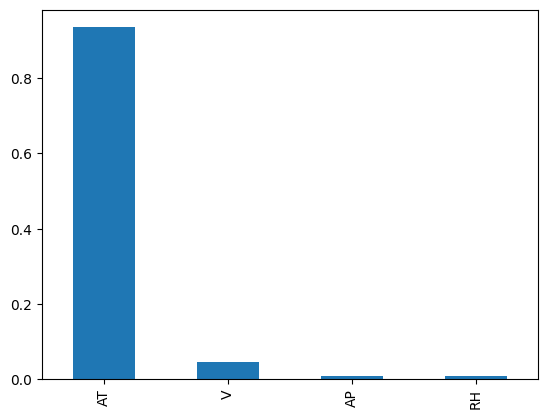

In [60]:
imp.plot(kind="bar")

In [61]:
xnew=pd.read_csv("PowerPlantTest.csv")


In [63]:
xnew_pre=numpipe.transform(xnew)

In [64]:
xnew_pre

,AT,V,AP,RH
0,0.717594,-0.259618,-0.208256,1.209376
1,1.523612,0.449845,-1.386664,-1.597546
2,0.045913,-0.574935,-1.723353,0.661684
3,2.463966,1.001650,-0.881632,-0.228316
4,0.448922,0.000000,-0.039912,-1.323700


In [62]:
xnew

,AT,V,AP,RH
0,25,51.0,1012,91
1,31,60.0,1005,50
2,20,47.0,1003,83
3,38,67.0,1008,70
4,23,NaN,1013,54


In [65]:
pred=best_dtr.predict(xnew_pre)

In [66]:
pred

array([447.356   , 433.83    , 448.192   , 432.837875, 451.435   ])

In [70]:
xnew["Estimated_Power_O/p"]=pred
xnew=xnew.round(4)

In [71]:
xnew

,AT,V,AP,RH,Estimated_Power_O/p
0,25,51.0,1012,91,447.3560
1,31,60.0,1005,50,433.8300
2,20,47.0,1003,83,448.1920
3,38,67.0,1008,70,432.8379
4,23,NaN,1013,54,451.4350


In [72]:
xnew.to_csv("results.csv",index=False)

### Saving Model

In [73]:
import joblib
joblib.dump(numpipe,"pre.joblib")

['pre.joblib']

In [74]:
joblib.dump(best_dtr,"dtr.joblib")

['dtr.joblib']

In [75]:
p=joblib.load("pre.joblib")
p

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [76]:
m=joblib.load("dtr.joblib")
m

DecisionTreeRegressor(max_depth=9, min_samples_leaf=9, min_samples_split=5)